<a href="https://colab.research.google.com/github/hiswaps/fyp/blob/main/fyp_model_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This notebook will contain the step-by-step procedures and explanations. Code here has been take from the notebook titled 'fyp_model_testing.ipynb' 
# Author: Swapnil Joshi
# Latest date of modification: 11th Jan 2022

In [4]:
#Just change the pip command to install any libraries
!pip install yfinance
!pip install hurst

     |████████████████████████████████| 6.4 MB 5.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [23]:
#Importing libraries

import yfinance as yf
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame

from hurst import compute_Hc, random_walk
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc


In [24]:
#Fetching the data: 

eminispx = yf.Ticker("ES=F")
vix = yf.Ticker("^VIX")


hist_spx = eminispx.history(period="max")
hist_vix = vix.history(start="2000-09-18")

# Making the data readable

spx_px = hist_spx.drop(['Dividends','Volume','Stock Splits'],1)
vix_px = hist_vix.drop(['Dividends','Volume','Stock Splits'],1)

spx_px.rename(columns={'Open': 'open_spx', 'High': 'high_spx', 'Low': 'low_spx', 'Close': 'close_spx'}, inplace=True)
vix_px.rename(columns={'Open': 'open_vix', 'High': 'high_vix', 'Low': 'low_vix', 'Close': 'close_vix'}, inplace=True)

price_data = pd.concat([spx_px,vix_px], axis=1)
price_data = price_data.dropna()

price_data

,open_spx,high_spx,low_spx,close_spx,open_vix,high_vix,low_vix,close_vix
Date,,,,,,,,
2000-09-18,1485.25,1489.75,1462.25,1467.50,18.879999,20.350000,18.780001,20.250000
2000-09-19,1467.00,1482.75,1466.75,1478.50,20.219999,20.250000,19.540001,19.540001
2000-09-20,1478.75,1480.50,1450.25,1469.50,19.990000,21.180000,19.920000,19.930000
2000-09-21,1470.25,1474.00,1455.50,1469.50,20.170000,20.709999,20.010000,20.180000
2000-09-22,1454.75,1471.00,1436.75,1468.50,22.090000,22.660000,20.740000,20.740000
...,...,...,...,...,...,...,...,...
2022-01-04,4785.25,4808.25,4764.50,4784.25,16.570000,17.809999,16.340000,16.910000
2022-01-05,4783.50,4788.25,4689.50,4692.50,17.070000,20.170000,16.580000,19.730000
2022-01-06,4692.00,4715.75,4662.00,4687.50,20.290001,21.059999,19.080000,19.610001


In [25]:
#Define a function to calculate the Heikin-Ashi candle values (OHLC): 

def heikin_ashi(df):
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open_spx', 'high_spx', 'low_spx', 'close_spx'])
    heikin_ashi_df['close_spx'] = (df['open_spx'] + df['high_spx'] + df['low_spx'] + df['close_spx']) / 4    
    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['open_spx'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i-1, 0] + heikin_ashi_df.iat[i-1, 3]) / 2

    heikin_ashi_df['high_spx'] = heikin_ashi_df.loc[:, ['open_spx', 'close_spx']].join(df['high_spx']).max(axis=1)
    heikin_ashi_df['low_spx'] = heikin_ashi_df.loc[:, ['open_spx', 'close_spx']].join(df['low_spx']).min(axis=1)   
    return heikin_ashi_df

In [26]:
hadf = heikin_ashi(price_data) #Converting candlesticks to Heikin Ashi


#Creating a dataframe with only open prices (for both Heikin-Ashi and normal candlesticks)

#Why use open prices instead of closing prices? 

'''
- Open prices are better because the strategy will always make a trade at the open price.
- This is especially important for the Heikin Ashi candles
- In the case of Heikin Ashi, if we use close prices instead of the open, the trades will be made at 
prices that do not exist (more precisely, at past prices), and that is inaccurate.

'''

data_open = pd.DataFrame(hadf['open_spx'])
data_open.columns = ['open_hadf']
data_open['open_spx'] = pd.DataFrame(price_data['open_spx'])

In [27]:
#EMAs (EMA is better because it assigns more weight to recent values and less to the old ones)

data_open['EMA_1'] = data_open['open_hadf'].ewm(span=1, adjust=False).mean()
data_open['EMA_5'] = data_open['open_hadf'].ewm(span=5, adjust=False).mean()

data_open

,open_hadf,open_spx,EMA_1,EMA_5
2000-09-18,1485.25,1485.25,1485.250000,1485.250000
2000-09-19,1480.72,1467.00,1480.718750,1483.739583
2000-09-20,1477.23,1478.75,1477.234375,1481.571181
2000-09-21,1473.49,1470.25,1473.492188,1478.878183
2000-09-22,1470.4,1454.75,1470.402344,1476.052903
...,...,...,...,...
2022-01-04,4771.48,4785.25,4771.475570,4755.372332
2022-01-05,4778.52,4783.50,4778.519035,4763.087899
2022-01-06,4758.48,4692.00,4758.478267,4761.551355
2022-01-07,4723.9,4695.00,4723.895384,4748.999365


In [28]:
data_open['hadf_pct_change'] = data_open['open_hadf'].pct_change()
data_open['hadf_log_return'] = np.log(1 + data_open.hadf_pct_change)

data_open = data_open.dropna()
data_open

#END OF DATA PREPROCESSING

,open_hadf,open_spx,EMA_1,EMA_5,hadf_pct_change,hadf_log_return
2000-09-19,1480.72,1467.00,1480.718750,1483.739583,-0.003051,-0.003055
2000-09-20,1477.23,1478.75,1477.234375,1481.571181,-0.002353,-0.002356
2000-09-21,1473.49,1470.25,1473.492188,1478.878183,-0.002533,-0.002536
2000-09-22,1470.4,1454.75,1470.402344,1476.052903,-0.002097,-0.002099
2000-09-25,1464.08,1469.50,1464.076172,1472.060659,-0.004302,-0.004312
...,...,...,...,...,...,...
2022-01-04,4771.48,4785.25,4771.475570,4755.372332,0.000516,0.000516
2022-01-05,4778.52,4783.50,4778.519035,4763.087899,0.001476,0.001475
2022-01-06,4758.48,4692.00,4758.478267,4761.551355,-0.004194,-0.004203
2022-01-07,4723.9,4695.00,4723.895384,4748.999365,-0.007268,-0.007294


In [77]:
# MONTE CARLO SIMULATION - generating a random time series using the statistical properties of the data
# This time series will be used later to test the ML models

data_copy = data_open.copy(deep=True)
simulation = pd.DataFrame()

mu, sigma = data_copy['hadf_log_return'].mean(), data_copy['hadf_log_return'].std() #Mean and Stdev for the new timeseries

sim_rets = np.random.normal(mu, sigma, 252)
initial = data_copy['open_hadf'].iloc[-1]

simulation['open_hadf'] = initial * (sim_rets + 1).cumprod()
simulation['EMA_5'] = simulation['open_hadf'].ewm(span=5, adjust=False).mean()
simulation['hadf_pct_change'] = simulation['open_hadf'].pct_change()
simulation['hadf_log_return'] = np.log(1 + simulation.hadf_pct_change)

simulation = simulation.dropna()


# Adding a new column for the direction (based on the returns)

NaN = np.nan
simulation['direction'] = NaN

simulation.direction = np.where(simulation['hadf_pct_change'] > 0,   'UP', 'DOWN')

simulation
#simulation['open_hadf'].plot(figsize=(20,8))
#simulation['EMA_5'].plot(figsize=(20,8))

,open_hadf,EMA_5,hadf_pct_change,hadf_log_return,direction
1,4712.703913,4703.817254,0.002837,0.002833,UP
2,4699.415533,4702.350013,-0.002820,-0.002824,DOWN
3,4720.297080,4708.332369,0.004443,0.004434,UP
4,4730.202024,4715.622254,0.002098,0.002096,UP
5,4746.876264,4726.040257,0.003525,0.003519,UP
...,...,...,...,...,...
247,5691.670255,5679.976324,0.003288,0.003283,UP
248,5685.323467,5681.758705,-0.001115,-0.001116,DOWN
249,5614.728779,5659.415396,-0.012417,-0.012495,DOWN
250,5629.310236,5649.380343,0.002597,0.002594,UP


In [30]:
#START OF EDA

#Now that we have done the preliminary data preprocessing, we can start working on some basic tests and explore the data further

#1 Simple describe() function [in-built]

data_open.describe()

,open_spx,EMA_1,EMA_5,hadf_pct_change,hadf_log_return
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,1785.317304,1784.204537,1782.992537,0.000232,0.000215
std,873.111438,871.441453,869.427775,0.005743,0.005757
min,674.750000,688.103873,700.309474,-0.048754,-0.049983
25%,1166.437500,1165.336269,1165.656245,-0.002335,-0.002338
50%,1400.375000,1399.005061,1399.161988,0.000736,0.000736
75%,2156.562500,2152.477472,2151.044422,0.003307,0.003302
max,4785.250000,4778.519035,4763.087899,0.031441,0.030957


In [34]:
# We can see from the results above that the time series for prices is definitely not stationary
# However, the percentage and log returns have a good chance to be stationary (mean returns are realistic and will not change with time. Or at least, haven't yet)

# Let us now try to perform the ADF test (Dickey-Fuller test) to check the stationarity of a time series

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#ADF on % returns: 
print("ADF on RETURNS:")
print("")
adf_test(data_open['hadf_pct_change'])
print("")
#ADF on log returns: 
print("ADF on LOG RETURNS:")
print("")
adf_test(data_open['hadf_log_return'])

ADF on RETURNS:

Results of Dickey-Fuller Test:
Test Statistic                -1.740512e+01
p-value                        4.921756e-30
#Lags Used                     1.600000e+01
Number of Observations Used    5.343000e+03
Critical Value (1%)           -3.431574e+00
Critical Value (5%)           -2.862081e+00
Critical Value (10%)          -2.567058e+00
dtype: float64

ADF on LOG RETURNS:

Results of Dickey-Fuller Test:
Test Statistic                -1.735826e+01
p-value                        5.222206e-30
#Lags Used                     1.600000e+01
Number of Observations Used    5.343000e+03
Critical Value (1%)           -3.431574e+00
Critical Value (5%)           -2.862081e+00
Critical Value (10%)          -2.567058e+00
dtype: float64


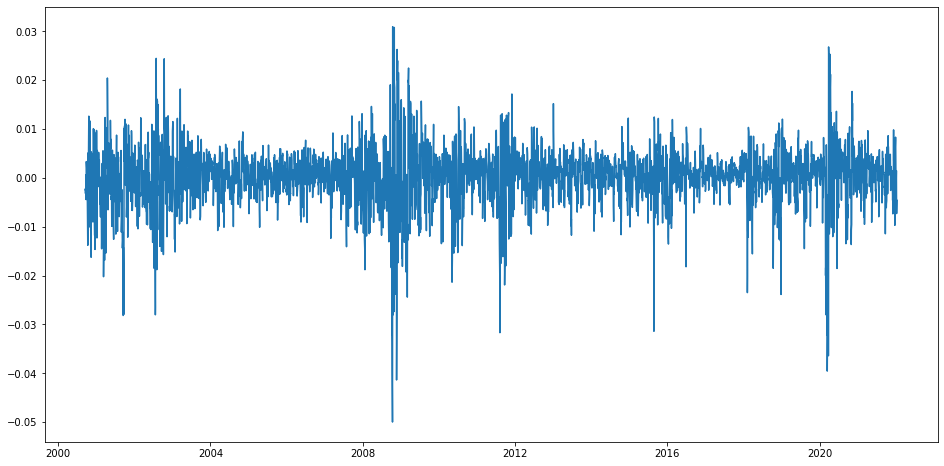

In [35]:
plt.figure(figsize=(16,8))
plt.plot(data_open['hadf_log_return'])
plt.show()

In [16]:
# Null Hypothesis: Series is non-stationary or series has a unit root.
# Alternate Hypothesis: Series is stationary or series has no unit root.


# From the test above, we can see that the Test Statistic < (all the critical values) and p-value < 0.05 --> So we reject the Null Hypothesis
# The p-value is extremely small, which indicates that there is strong evidence in favour of the Alternative Hypothesis

In [18]:
# The data does look normal to an extent. However, the spike around the center indicates that there is some Positive Kurtosis in the data

# What should be our next steps? 

'''
A few ideas:

- Now that we have established the fact that the returns are stationary, we can go ahead and start experimenting with some classic ML models.
Given that the strategy in mind is a trend following strat, there is a decent chance the the ML models should be able to pick up/identify the momentum 
of the time series. This is because when the markets are trending, say upwards, positive returns will be followed by more positive returns (thus creating the trend)

- Binary classification approach --> You can convert this time series problem into a binary forecasting one, and then experiment by using 3 different models:
  - Logistic Regression
  - Random Forest Classifier

- Timeseries Analysis: 
  - ARIMA model: the classic model for analysing time series. 

'''

'\nA few ideas:\n\n- Now that we have established the fact that the returns are stationary, we can go ahead and start experimenting with some classic ML models.\nGiven that the strategy in mind is a trend following strat, there is a decent chance the the ML models should be able to pick up/identify the momentum \nof the time series. This is because when the markets are trending, say upwards, positive returns will be followed by more positive returns (thus creating the trend)\n\n- Binary classification approach --> You can convert this time series problem into a binary forecasting one, and then experiment by using 3 different models:\n  - Logistic Regression\n  - Random Forest Classifier\n\n- Timeseries Analysis: \n  - ARIMA model: the classic model for analysing time series. \n\n'

In [37]:
# 1.BINARY CLASSIFICATION APPROACH using LOGISTIC REGRESSION:

"""
- In the section below, we will try to model this problem as a binary classification problem. The input parameters would be: EMA_5 and 'open_hadf' price
- The model's output will be 'hadf_pct_change'
- We will then test this model on the 'simulation' dataframe that we generated previously

- Why are we doing this?

- We have already seen that trends exist when the HADF open prices crossover the moving averages
- When the open_hadf crosses the EMA_5 upwards, there is a tendency for it to go further up (therefore a positive 'hadf_pct_change" for the next step).
- In a way, this is primitive form of prediction that uses the price and the EMA_5 to predict whether the future returns will trend upwards or downwards.


So let us try to model this as a forecasting problem and take a look at the results we obtain: 

Note: I am quite certain that this approach will not work well. But anyway, let us go ahead and try

"""

'\n- In the section below, we will try to model this problem as a binary classification problem. The input parameters would be: EMA_5 and \'open_hadf\' price\n- The model\'s output will be \'hadf_pct_change\'\n- We will then test this model on the \'simulation\' dataframe that we generated previously\n\n- Why are we doing this?\n\n- We have already seen that trends exist when the HADF open prices crossover the moving averages\n- When the open_hadf crosses the EMA_5 upwards, there is a tendency for it to go further up (therefore a positive \'hadf_pct_change" for the next step).\n- In a way, this is primitive form of prediction that uses the price and the EMA_5 to predict whether the future returns will trend upwards or downwards.\n\n\nSo let us try to model this as a forecasting problem and take a look at the results we obtain: \n\nNote: I am quite certain that this approach will not work well. But anyway, let us go ahead and try\n\n'

In [38]:
# CONVERTING THE DATA FOR A BINARY CLASSIFICATION PROBLEM:

# Adding a new column for the direction (based on the returns)

NaN = np.nan
data_open['direction'] = NaN

data_open.direction = np.where(data_open['hadf_pct_change'] > 0,   'UP', 'DOWN')

data_open

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,open_hadf,open_spx,EMA_1,EMA_5,hadf_pct_change,hadf_log_return,direction
2000-09-19,1480.72,1467.00,1480.718750,1483.739583,-0.003051,-0.003055,DOWN
2000-09-20,1477.23,1478.75,1477.234375,1481.571181,-0.002353,-0.002356,DOWN
2000-09-21,1473.49,1470.25,1473.492188,1478.878183,-0.002533,-0.002536,DOWN
2000-09-22,1470.4,1454.75,1470.402344,1476.052903,-0.002097,-0.002099,DOWN
2000-09-25,1464.08,1469.50,1464.076172,1472.060659,-0.004302,-0.004312,DOWN
...,...,...,...,...,...,...,...
2022-01-04,4771.48,4785.25,4771.475570,4755.372332,0.000516,0.000516,UP
2022-01-05,4778.52,4783.50,4778.519035,4763.087899,0.001476,0.001475,UP
2022-01-06,4758.48,4692.00,4758.478267,4761.551355,-0.004194,-0.004203,DOWN
2022-01-07,4723.9,4695.00,4723.895384,4748.999365,-0.007268,-0.007294,DOWN


In [55]:
# Splitting the data into test and train: 

X_train, X_test, y_train, y_test = train_test_split(data_open[['open_hadf','EMA_5']], data_open.direction, test_size=0.4)

In [40]:
# Building a model class

model = LogisticRegression()
classifier = model.fit(X_train, y_train)

Model's Accuracy: 0.8148320895522388
              precision    recall  f1-score   support

        DOWN       0.80      0.75      0.77       890
          UP       0.83      0.86      0.85      1254

    accuracy                           0.81      2144
   macro avg       0.81      0.80      0.81      2144
weighted avg       0.81      0.81      0.81      2144



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


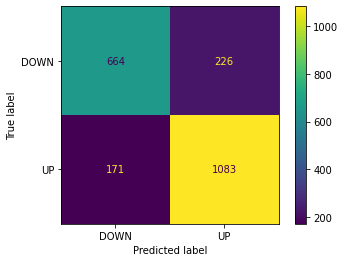

In [78]:
# Testing the model on X_test (part of the original data): 

y_pred = model.predict(X_test)
print("Model's Accuracy:",model.score(X_test, y_test))
print(classification_report(y_test,y_pred))

# Plotting a confusion matrix 

plot_confusion_matrix(model, X_test, y_test)
plt.show()

Model's Accuracy: 0.7649402390438247
              precision    recall  f1-score   support

        DOWN       0.78      0.63      0.70       108
          UP       0.76      0.87      0.81       143

    accuracy                           0.76       251
   macro avg       0.77      0.75      0.75       251
weighted avg       0.77      0.76      0.76       251



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


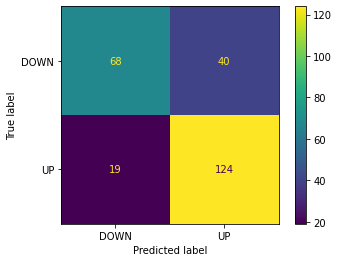

In [79]:
# Testing the model on the 'simulation' dataframe (random simulated data): 

#simX_train, simX_test, simY_train, simY_test = train_test_split(simulation[['open_hadf','EMA_5']], simulation.direction, test_size=0.999)

simX_test = simulation.copy(deep=True)
simY_test = simulation.copy(deep=True)

simX_test = simX_test.drop(['direction','hadf_pct_change','hadf_log_return'],1)
simY_test = simY_test.drop(['open_hadf','EMA_5','hadf_pct_change','hadf_log_return'],1)

simulation_pred = model.predict(simX_test)
print("Model's Accuracy:",model.score(simX_test, simY_test))
print(classification_report(simY_test,simulation_pred))

# Plotting a confusion matrix 

plot_confusion_matrix(model, simX_test, simY_test)
plt.show()

In [84]:
# 2.BINARY CLASSIFICATION APPROACH using a RANDOM FOREST CLASSIFIER:

# Building and fitting the model

#rf = RandomForestClassifier(n_estimators = 200)
rf = RandomForestClassifier(max_depth=900, max_samples=2000, n_estimators = 50)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=900, max_samples=2000, n_estimators=50)

Model's Accuracy: 0.7327425373134329
              precision    recall  f1-score   support

        DOWN       0.69      0.65      0.67       890
          UP       0.76      0.79      0.78      1254

    accuracy                           0.73      2144
   macro avg       0.72      0.72      0.72      2144
weighted avg       0.73      0.73      0.73      2144




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


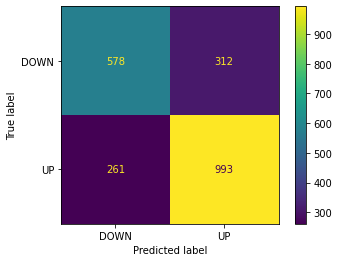

In [85]:
# Testing the model on X_test (part of the original data): 

y_preds = rf.predict(X_test)
print("Model's Accuracy:",rf.score(X_test, y_test))
print(classification_report(y_test,y_preds))
print("")
# Plotting a confusion matrix 
plot_confusion_matrix(rf, X_test, y_test)
plt.show()

Model's Accuracy: 0.6175298804780877
              precision    recall  f1-score   support

        DOWN       0.70      0.19      0.30       108
          UP       0.61      0.94      0.74       143

    accuracy                           0.62       251
   macro avg       0.65      0.57      0.52       251
weighted avg       0.65      0.62      0.55       251



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


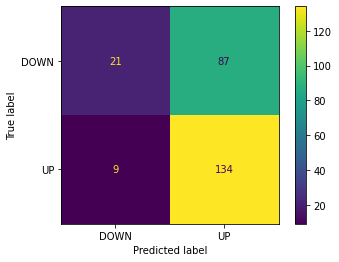

In [86]:
# Testing the model on the 'simulation' dataframe (random simulated data): 

#simX_train, simX_test, simY_train, simY_test = train_test_split(simulation[['open_hadf','EMA_5']], simulation.direction, test_size=0.999)

simX_test = simulation.copy(deep=True)
simY_test = simulation.copy(deep=True)

simX_test = simX_test.drop(['direction','hadf_pct_change','hadf_log_return'],1)
simY_test = simY_test.drop(['open_hadf','EMA_5','hadf_pct_change','hadf_log_return'],1)

simulation_preds = rf.predict(simX_test)
print("Model's Accuracy:",rf.score(simX_test, simY_test))
print(classification_report(simY_test,simulation_preds))

# Plotting a confusion matrix 

plot_confusion_matrix(rf, simX_test, simY_test)
plt.show()

In [88]:
# KEY POINTS - Classification Approach

"""
- We can clearly see that Logistic Regression yields better results than RF Classifier (accuracy and f1 score)

  - Find out why exactly is this the case? It certainly has something to do with the way these models work
  - Hyperparameter tuning [tune the parameters of the Logistic Regression classifier]
  - Identify better methods to evaluate the model's performance
    - k-fold cross validation (a resampling procedure used to evaluate machine learning models on a limited data sample.)
  - Test the Logistic Regression model on newly generated (or random data) (should be more or less similar to the price data)

"""

"\n- We can clearly see that Logistic Regression yields better results than RF Classifier (accuracy and f1 score)\n\n  - Find out why exactly is this the case? It certainly has something to do with the way these models work\n  - Hyperparameter tuning [tune the parameters of the Logistic Regression classifier]\n  - Identify better methods to evaluate the model's performance\n    - k-fold cross validation (a resampling procedure used to evaluate machine learning models on a limited data sample.)\n  - Test the Logistic Regression model on newly generated (or random data) (should be more or less similar to the price data)\n\n"

In [87]:
# OK, SO IMPLEMENTING A CLASSIFICATION MODEL HAS GIVEN US SOME INTERESTING RESULTS. IT SEEMS LIKE THE MODEL CAN PERFORM THE CLASSIFICATION TASK FAIRLY WELL with Logistic Regression
# and not so well with the Random Forest Classifier 

# Let us now add another column for the momentum overlay:
#pd.set_option('display.max_rows', 100)

data_open
data_open['long'] = np.where(data_open.EMA_1 > data_open.EMA_5, 1,0)
data_open['Signal'] = data_open['long'].diff()

# We need to shift the signals one step down. 
# For instance, if the signal was -1 on Jan 6th, 2022, the trade will be made at the open price of Jan 7th, 2022
# Therefore, we need to shift the signals one step down

data_open['Signal'] = data_open['Signal'].shift(1)
#data_open.tail(10)
data_open

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

,open_hadf,open_spx,EMA_1,EMA_5,hadf_pct_change,hadf_log_return,direction,long,Signal,buy,sell
2000-09-19,1480.72,1467.00,1480.718750,1483.739583,-0.003051,-0.003055,DOWN,0,NaN,NaN,NaN
2000-09-20,1477.23,1478.75,1477.234375,1481.571181,-0.002353,-0.002356,DOWN,0,NaN,NaN,NaN
2000-09-21,1473.49,1470.25,1473.492188,1478.878183,-0.002533,-0.002536,DOWN,0,0.0,NaN,NaN
2000-09-22,1470.4,1454.75,1470.402344,1476.052903,-0.002097,-0.002099,DOWN,0,0.0,NaN,NaN
2000-09-25,1464.08,1469.50,1464.076172,1472.060659,-0.004302,-0.004312,DOWN,0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-04,4771.48,4785.25,4771.475570,4755.372332,0.000516,0.000516,UP,1,0.0,NaN,NaN
2022-01-05,4778.52,4783.50,4778.519035,4763.087899,0.001476,0.001475,UP,1,0.0,NaN,NaN
2022-01-06,4758.48,4692.00,4758.478267,4761.551355,-0.004194,-0.004203,DOWN,0,0.0,NaN,NaN
2022-01-07,4723.9,4695.00,4723.895384,4748.999365,-0.007268,-0.007294,DOWN,0,-1.0,NaN,4695.0


In [72]:
#Creating another dataframe to do some testing with signals

opens = data_open.copy(deep=True)

#Creating buy and sell signals

opens['buy'] = np.where(opens['Signal'] == 1, opens['open_spx'], np.NaN)
opens['sell'] = np.where(opens['Signal'] == -1, opens['open_spx'], np.NaN)

#pd.set_option('display.max_rows', 100)
#opens.head(100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
#MAJOR ISSUE/PROBLEM:

"""

So even though using Heikin Ashi candles made things much smoother, there is another issue at hand: 
- Slippage (in this case, the difference between 'open_hadf' and 'open_spx')
- I did not anticipate that the slippage would be so high for daily timeframes (as high as 100 points)
- This will fuck up the strategy. I need data of lower timeframes to get good/significant results

Anyway, that is an issue I can fix by simply changing the data source and feeding in lower timeframe data

"""

"\n\nSo even though using Heikin Ashi candles made things much smoother, there is another issue at hand: \n- Slippage (in this case, the difference between 'open_hadf' and 'open_spx')\n- I did not anticipate that the slippage would be so high for daily timeframes (as high as 100 points)\n- This will fuck up the strategy. I need data of lower timeframes to get good/significant results\n\nAnyway, that is an issue I can fix by simply changing the data source and feeding in lower timeframe data\n\n"

In [32]:
# ARIMA approach:

# Now that we have explored the classifiers, let us try analysing a time series the traditional way - using ARIMA 



